# 00.Importing Libraries

In [17]:
import shap
import xgboost
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt
from matplotlib import pyplot
from keras.layers import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.models import Sequential
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor


# 01.Helpers

## 01.01 Constants

In [43]:
features = ['date', 'hospitalizations', 'heat_index', 'heat_index_sum', 'heat_index_std', 'heat_index99','heat_index95', 'temperature_mean', 'temperature_max',
           'temperature_min', 'wind_speed_mean', 'humidity_mean','lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3']

feature_without_target = ['heat_index', 'heat_index_sum', 'heat_index_std', 'heat_index99','heat_index95', 'temperature_mean', 'temperature_max',
           'temperature_min', 'wind_speed_mean', 'humidity_mean','lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3']

In [19]:
test_start_date = "2017-01-01"

## 01.02 Functions

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [21]:
def train_test_split(df, test_date, target_variable):
    # separação por tempo
    df_train = df[df.index < test_date]
    df_test  = df[df.index >= test_date]

    # remoção da variável target
    y_train = df_train[target_variable]
    y_test  = df_test[target_variable]

    df_train = df_train.drop(columns=target_variable).copy()
    df_test  = df_test.drop(columns=target_variable).copy()

    print(df_train.shape, y_train.shape)
    print(df_test.shape, y_test.shape)

    return df_train, df_test, y_train, y_test

In [22]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [23]:
def data_reconversion(scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled, y_pred):
    df_train_original = scaler.inverse_transform(df_train_scaled)
    df_test_original = scaler.inverse_transform(df_test_scaled)

    y_train_original = scaler_target.inverse_transform(y_train_scaled)
    y_test_original = scaler_target.inverse_transform(y_test_scaled)
    y_pred_original = scaler_target.inverse_transform(y_pred)

    return df_train_original, df_test_original, y_train_original, y_test_original, y_pred_original

In [24]:
def metrics(y, predicted):
    mae = mean_absolute_error(y, predicted)
    mse = mean_squared_error(y, predicted)
    rmse = mean_squared_error(y, predicted)
    mape = np.mean(np.abs((y - predicted) / y)) * 100
    r2 = r2_score(y, predicted)
    return mae, mse, rmse, mape, r2

def print_metrics(y, predicted):
    mae, mse, rmse, mape, r2 = metrics(y, predicted)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-Squared (R²): {r2:.2f}")

In [25]:
def build_model(hp):
    model = Sequential()
    # LSTM layers with variable number of units
    model.add(LSTM(units=hp.Int('units_layer1', min_value=10, max_value=100, step=5), return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(units=hp.Int('units_layer2', min_value=10, max_value=100, step=5), return_sequences=True))
    model.add(LSTM(units=hp.Int('units_layer3', min_value=10, max_value=100, step=5)))
    model.add(Dense(1))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mse'
    )
    return model

In [26]:
def grid_search_cv(model, X_train, y_train, X_test, scoring='neg_mean_absolute_percentage_error', n_splits=12, test_size=12, random_state=42):
    # print(f"n_splits={n_splits}, test_size={test_size}")
    # cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)

    # Modelo
    model = model(random_state=42)

    # Definir os hiperparâmetros para o GridSearch
    param_grid = {
        'n_estimators': [150, 200],  # Número de árvores
        'learning_rate': [0.1, 0.2, 0.5],  # Taxa de aprendizado
        'max_depth': [3, 5],  # Profundidade máxima das árvores
        'subsample': [0.6, 0.8, 1.0],  # Taxa de amostragem
        'colsample_bytree': [0.8, 1.0],  # Fração de colunas por árvore
        'colsample_bylevel': [0.6, 0.8, 1.0],
        'gamma': [0, 0.2]  # Reduz o crescimento da árvore
    }

    # Configurar o GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, verbose=1, n_jobs=-1, cv=tscv, scoring='neg_mean_squared_error')

    # Executar a busca
    grid_search.fit(X_train, y_train)

    # # Resultados
    # print("Melhores parâmetros:", grid_search.best_params_)

    best_params = {
        "n_estimators": grid_search.best_params_['n_estimators'],
        "colsample_bytree":grid_search.best_params_['colsample_bytree'],
        "colsample_bylevel":grid_search.best_params_['colsample_bylevel'],
        "gamma": grid_search.best_params_['gamma'],
        "learning_rate": grid_search.best_params_['learning_rate'],
        "max_depth": grid_search.best_params_['max_depth'],
        "subsample": grid_search.best_params_['subsample'],
    }

    y_pred = grid_search.predict(X_test)

    return best_params, y_pred

In [55]:
def final_model(best_result, df_train, y_train, df_test, y_test, feature_names):
    model = XGBRegressor(
        n_estimators = best_result['metrics']['best_params']['n_estimators'],  # Número de árvores
        colsample_bytree = best_result['metrics']['best_params']['colsample_bytree'],
        colsample_bylevel = best_result['metrics']['best_params']['colsample_bylevel'],
        gamma = best_result['metrics']['best_params']['gamma'],
        learning_rate = best_result['metrics']['best_params']['learning_rate'],  # Taxa de aprendizado
        max_depth = best_result['metrics']['best_params']['max_depth'],  # Profundidade máxima da árvore
        subsample=   best_result['metrics']['best_params']['subsample']
    )

    # Treinar o modelo com os dados escalados
    model.fit(df_train_scaled, y_train_scaled)

    # Fazer previsões no conjunto de teste
    y_pred = model.predict(df_test)

    # F-Score
    xgboost.plot_importance(model)
    plt.title("xgboost.plot_importance(model)")

    xgboost.plot_importance(model, importance_type="cover")
    plt.title('xgboost.plot_importance(model, importance_type="cover")')
    plt.show()

    # xgboost.plot_importance(model, importance_type="gain")
    # plt.title('xgboost.plot_importance(model, importance_type="gain")')

    # Criar o explicador SHAP
    explainer = shap.Explainer(model, feature_names=feature_names)
    # explainer = shap.Explainer(model, feature_names=feature_names)

    # Calcular valores SHAP
    shap_values = explainer(df_test)

    shap.waterfall_plot(shap_values[0])

    print("\n\n\nSHAP Summary Plot\n\n\n");

    shap.summary_plot(shap_values, df_test)

In [28]:
def data_normalization(df_train, df_test, y_train, y_test):
    # Para as features
    scaler               = MinMaxScaler(feature_range=(0, 1))
    df_train_scaled      = scaler.fit_transform(df_train)
    df_test_scaled       = scaler.transform(df_test)

    # Para a variável alvo
    scaler_target       = MinMaxScaler(feature_range=(0, 1))
    y_train_scaled      = scaler_target.fit_transform(y_train.to_frame())
    y_test_scaled       = scaler_target.transform(y_test.to_frame())

    print(df_train_scaled.shape, y_train_scaled.shape)
    print(df_test_scaled.shape, y_test_scaled.shape)

    return scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled

In [29]:
def get_best_result(results):
    return max(results, key=lambda x: (x['metrics']['r2'], -x['metrics']['rmse']))

# 02.Importing Datasets

In [30]:
dataset = pd.read_csv('../../Preprocessing/dataset.csv', 
                   header=0, 
                   index_col=0,
                   usecols=features)

dataset

,hospitalizations,heat_index,heat_index_sum,heat_index_std,heat_index99,heat_index95,temperature_mean,temperature_max,temperature_min,wind_speed_mean,humidity_mean,lag_heat_index_1,lag_heat_index_2,lag_heat_index_3
date,,,,,,,,,,,,,,
2000-12-01,4266.0,24.154261,17970.77,4.999719,37.8966,33.5380,23.575000,35.4,13.4,1.826613,70.836022,21.132403,19.318992,15.300694
2001-01-01,4032.0,26.316156,19579.22,4.452698,37.8471,34.6685,25.136962,35.4,17.0,1.777016,75.375000,24.154261,21.132403,19.318992
2001-02-01,3888.0,27.119464,18224.28,4.274063,37.7548,35.3940,25.691071,34.2,20.2,1.916518,76.424107,26.316156,24.154261,21.132403
2001-03-01,3658.0,26.113387,19428.36,4.220196,36.7670,34.4155,24.985349,34.4,16.3,1.629704,76.383065,27.119464,26.316156,24.154261
2001-04-01,4022.0,21.383903,15396.41,3.427034,31.0030,28.0215,21.038333,30.8,11.9,1.455139,81.152778,26.113387,27.119464,26.316156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01,3172.0,16.708185,12430.89,5.357643,33.1822,27.3330,16.684946,32.5,7.1,1.345027,85.837366,22.136556,25.621075,27.636221
2024-06-01,3640.0,17.283889,12444.40,5.390826,29.7834,26.8025,17.371111,31.5,4.6,1.265139,80.636111,16.708185,22.136556,25.621075
2024-07-01,3689.0,13.313495,9905.24,4.740495,26.8167,21.7780,13.736022,28.9,3.4,1.123387,81.887097,17.283889,16.708185,22.136556


In [31]:
dataset.columns

Index(['hospitalizations', 'heat_index', 'heat_index_sum', 'heat_index_std',
       'heat_index99', 'heat_index95', 'temperature_mean', 'temperature_max',
       'temperature_min', 'wind_speed_mean', 'humidity_mean',
       'lag_heat_index_1', 'lag_heat_index_2', 'lag_heat_index_3'],
      dtype='object')

# 03.Preprocessing

## 03.01 Remoção ano 2000

In [32]:
dataset = dataset[dataset.index < "2020-01-01"]

test_start_date = '2017-01-01'

# 04.Model training

## 04.01 Split train and test

In [33]:
df_train, df_test, y_train, y_test = train_test_split(dataset, test_start_date, 'hospitalizations')

(193, 13) (193,)
(36, 13) (36,)


## 04.02 Normalization

In [34]:
scaler, scaler_target, df_train_scaled, df_test_scaled, y_train_scaled, y_test_scaled = data_normalization(df_train, df_test, y_train, y_test)

(193, 13) (193, 1)
(36, 13) (36, 1)


## 04.03 XGBOOSTRegressor

In [35]:
results = []
n_splits = [3, 6, 12]
test_sizes = [3, 6, 12]

for n_split in n_splits:
    for test_size in test_sizes:
        best_params, y_pred = grid_search_cv(XGBRegressor, df_train_scaled, y_train_scaled, df_test_scaled, n_splits=n_split, test_size=test_size, random_state=42)
        mae, mse, rmse, mape, r2 = metrics(y_test_scaled, y_pred)

        results.append({
            "model_name": "XGBRegressor",
            "n_splits": n_split,
            "test_size": test_size,
            "metrics": { "best_params": best_params, "mae": mae, "mse": mse, "rmse": rmse, "mape": mape, "r2": r2 },
            "y_pred": y_pred
        })

print('### GridSearch finalizado! ###--')

Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Fitting 3 folds for each of 432 candidates, totalling 1296 fits
Fitting 6 folds for each of 432 candidates, totalling 2592 fits
Fitting 6 folds for each of 432 candidates, totalling 2592 fits
Fitting 6 folds for each of 432 candidates, totalling 2592 fits
Fitting 12 folds for each of 432 candidates, totalling 5184 fits
Fitting 12 folds for each of 432 candidates, totalling 5184 fits
Fitting 12 folds for each of 432 candidates, totalling 5184 fits
### GridSearch finalizado! ###--


In [36]:
best_result = get_best_result(results)

best_result

{'model_name': 'XGBRegressor',
 'n_splits': 12,
 'test_size': 3,
 'metrics': {'best_params': {'n_estimators': 150,
   'colsample_bytree': 1.0,
   'colsample_bylevel': 0.8,
   'gamma': 0.2,
   'learning_rate': 0.5,
   'max_depth': 3,
   'subsample': 0.8},
  'mae': 0.15418120311366193,
  'mse': 0.030249761397031297,
  'rmse': 0.030249761397031297,
  'mape': 82.5481313796953,
  'r2': -2.3778909042730243},
 'y_pred': array([0.39941597, 0.2904264 , 0.39941597, 0.47075823, 0.4644517 ,
        0.44724938, 0.44724938, 0.5201017 , 0.5201017 , 0.4911723 ,
        0.53156704, 0.35836834, 0.43120584, 0.39941597, 0.2904264 ,
        0.31531793, 0.38666022, 0.5201017 , 0.6041998 , 0.54682255,
        0.53156704, 0.5872173 , 0.5158752 , 0.35836834, 0.43120584,
        0.2904264 , 0.39941597, 0.31531793, 0.4644517 , 0.44724938,
        0.5201017 , 0.5201017 , 0.49521023, 0.4238682 , 0.47548053,
        0.31797358], dtype=float32)}

In [37]:
(
    df_train_original,
    df_test_original,
    y_train_original,
    y_test_original,
    y_pred_original
) = data_reconversion(
    scaler,
    scaler_target,
    df_train_scaled,
    df_test_scaled,
    y_train_scaled,
    y_test_scaled,
    best_result['y_pred'].reshape(-1, 1)
)

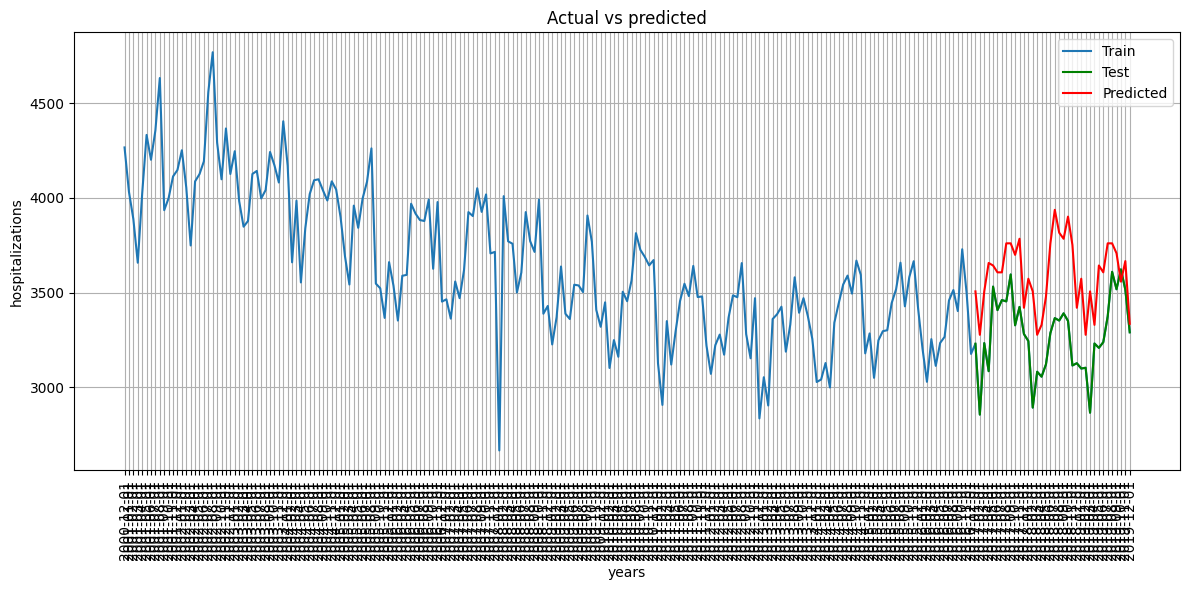

In [38]:
index = dataset[(dataset.index < test_start_date)].index
index_test = dataset[(dataset.index >= test_start_date)].index

plt.figure(figsize=(12, 6))
plt.plot(dataset.index, dataset['hospitalizations'], label='Train')
plt.plot(index_test, y_test_original, color='green', label='Test')
plt.plot(index_test, y_pred_original, color='red', label='Predicted')
plt.title("Actual vs predicted")
plt.xlabel('years')
plt.ylabel('hospitalizations')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [39]:
print_metrics(y_test_original, y_pred_original)

Mean Absolute Error (MAE): 323.78
Mean Squared Error (MSE): 133401.46
Root Mean Squared Error (RMSE): 133401.46
Mean Absolute Percentage Error (MAPE): 10.09%
R-Squared (R²): -2.38


## 04.04 Final Model

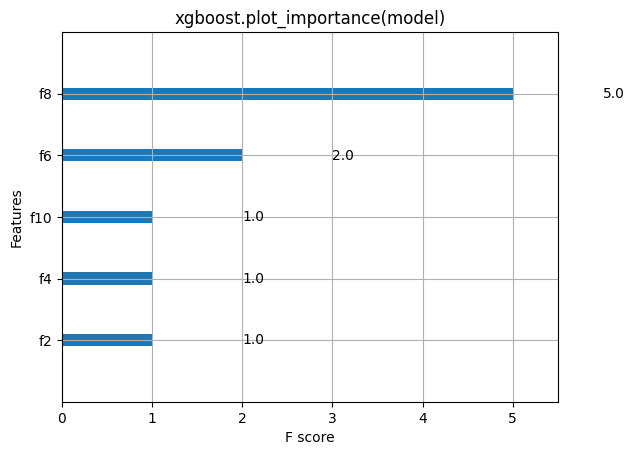

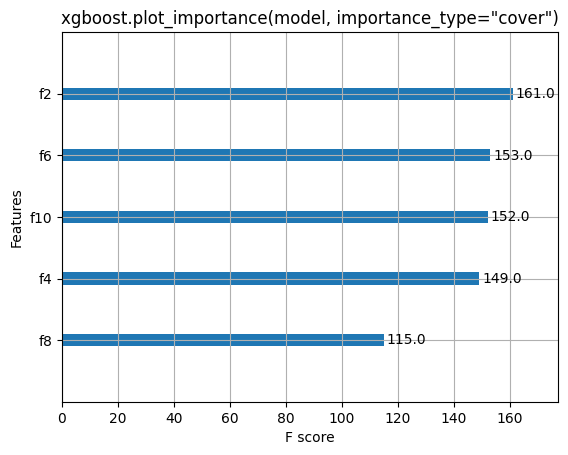

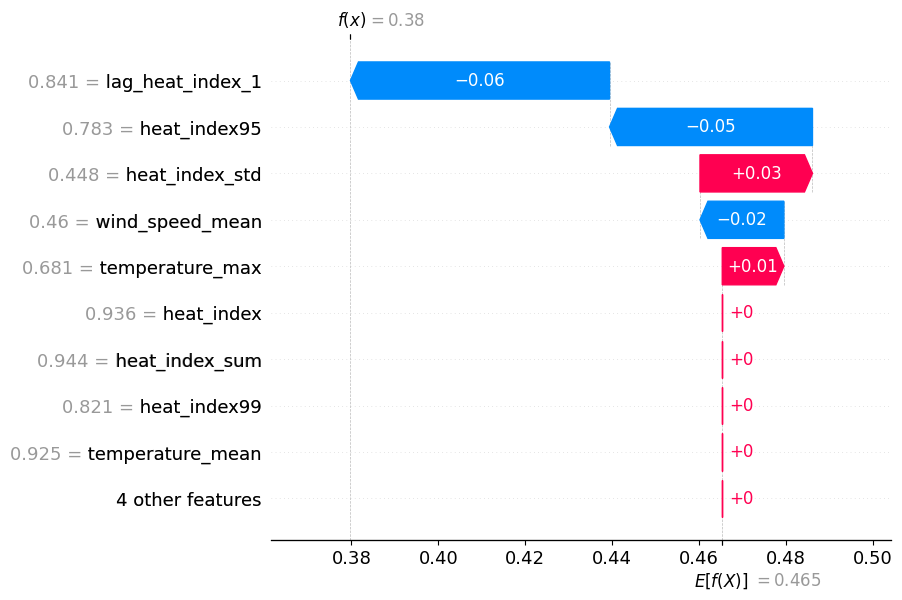




SHAP Summary Plot





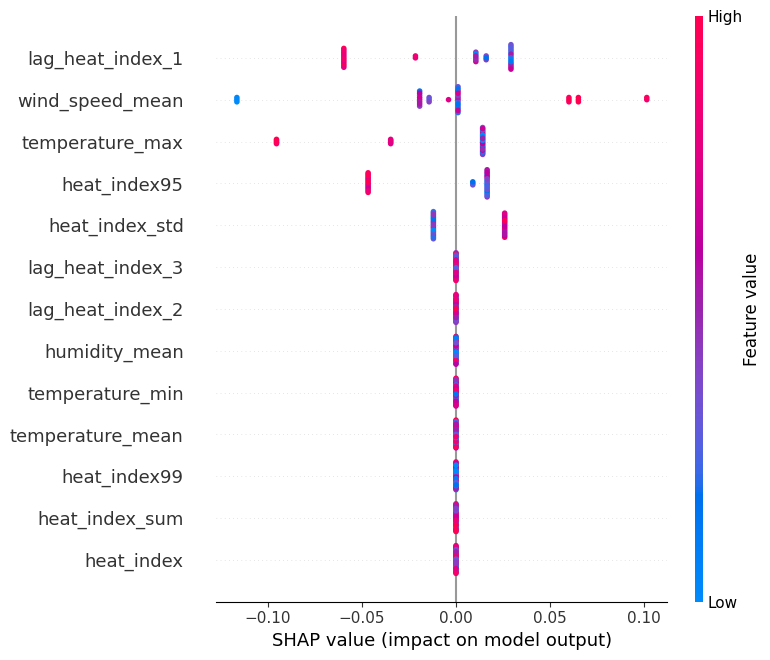

In [56]:
final_model(best_result, df_train_scaled, y_train_scaled, df_test_scaled, y_test_scaled, feature_without_target)

In [53]:
for index, key in enumerate(dataset[feature_without_target].columns):
    print(f"{index} - {key}")

0 - heat_index
1 - heat_index_sum
2 - heat_index_std
3 - heat_index99
4 - heat_index95
5 - temperature_mean
6 - temperature_max
7 - temperature_min
8 - wind_speed_mean
9 - humidity_mean
10 - lag_heat_index_1
11 - lag_heat_index_2
12 - lag_heat_index_3
